In [7]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from scipy.interpolate import interp1d
from pylab import rcParams
import pylab
%matplotlib inline
rcParams['figure.figsize'] = 18.5, 10.5

**Dataset Link**:https://archive.ics.uci.edu/ml/datasets/Localization+Data+for+Person+Activity

**Authors**: Eduardo Cesar, João Gris

In [8]:
# File location
PATH = "ConfLongDemo_JSI.txt"

# Lables for the sensors
ANKLE_LEFT = "010-000-024-033"
ANKLE_RIGHT = "010-000-030-096"
CHEST = "020-000-033-111"
BELT = "020-000-032-221"

# List of Activities
ACTIVITIES = ["walking", "falling", "lying down", "lying", "sitting down", "sitting",
              "standing up from lying", "on all fours", "sitting on the ground",
              "standing up from sitting", "standing up from sitting on the ground"]

In [9]:
# Reading the data
all_data = pd.read_csv(PATH, sep=",", names=["person", "label", "time_stamp", "date_time", "x", "y", "z", "activity"])
all_data.head()

,person,label,time_stamp,date_time,x,y,z,activity
0,A01,010-000-024-033,633790226051280329,27.05.2009 14:03:25:127,4.062931,1.892434,0.507425,walking
1,A01,020-000-033-111,633790226051820913,27.05.2009 14:03:25:183,4.291954,1.781140,1.344495,walking
2,A01,020-000-032-221,633790226052091205,27.05.2009 14:03:25:210,4.359101,1.826456,0.968821,walking
3,A01,010-000-024-033,633790226052361498,27.05.2009 14:03:25:237,4.087835,1.879999,0.466983,walking
4,A01,010-000-030-096,633790226052631792,27.05.2009 14:03:25:263,4.324462,2.072460,0.488065,walking


In [10]:
# Separating by events
all_data_values = all_data.values
events = {"walking": [], "falling": [], "lying down": [], "lying": [], "sitting down": [], "sitting": [],
          "standing up from lying": [], "on all fours": [], "sitting on the ground": [], "standing up from sitting": [],
          "standing up from sitting on the ground" : []}

def insert_event(new_event, action):
    ankle_left = []
    ankle_right = []
    chest = []
    belt = []
    for event in new_event:
        if event[1] == ANKLE_LEFT:
            ankle_left.append([event[4], event[5], event[6]])
        elif event[1] == ANKLE_RIGHT:
            ankle_right.append([event[4], event[5], event[6]])
        elif event[1] == CHEST:
            chest.append([event[4], event[5], event[6]])
        else:
            belt.append([event[4], event[5], event[6]])    
    if len(ankle_left) > 5 and len(ankle_right) > 5 and len(chest) > 5 and len(event) > 5:
        events[action].append([ankle_left, ankle_right, chest, belt])
    
new_event = []
for i in range(len(all_data_values)):
    if (i != 0 and all_data_values[i][7] != all_data_values[i - 1][7]) or i == len(all_data_values) - 1:
        insert_event(new_event, all_data_values[i - 1][7])
        new_event = []
    new_event.append(all_data_values[i])

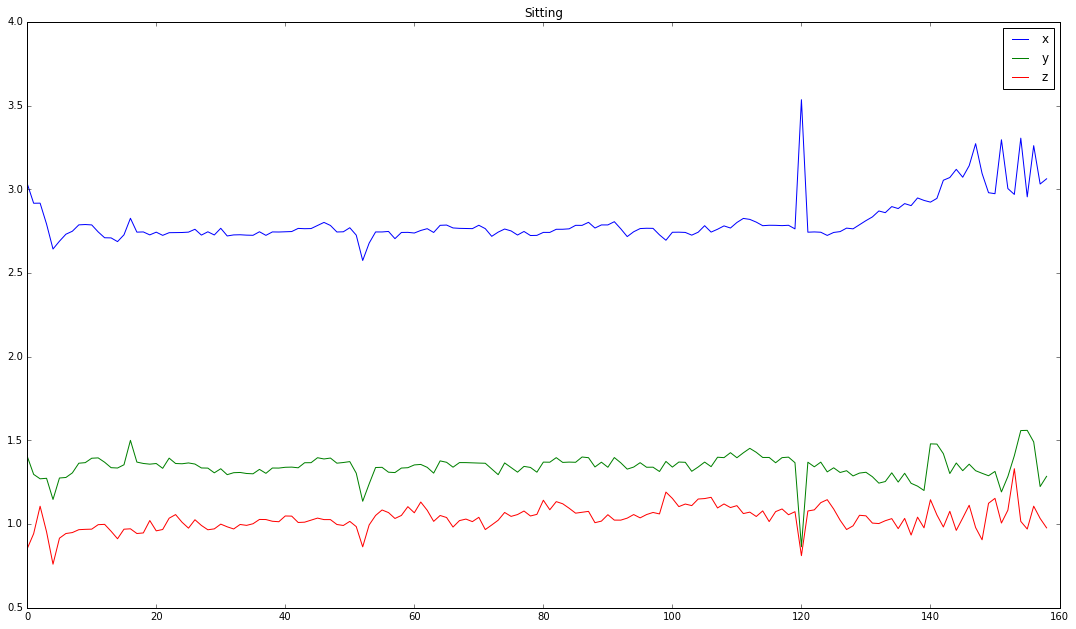

In [11]:
# sitting Plot Example
plt.plot([i[0] for i in events["sitting"][3][2]], label="x")
plt.plot([i[1] for i in events["sitting"][3][2]], label="y")
plt.plot([i[2] for i in events["sitting"][3][2]], label="z")
plt.title("Sitting")
plt.legend()
plt.savefig("figure_3")
plt.show()

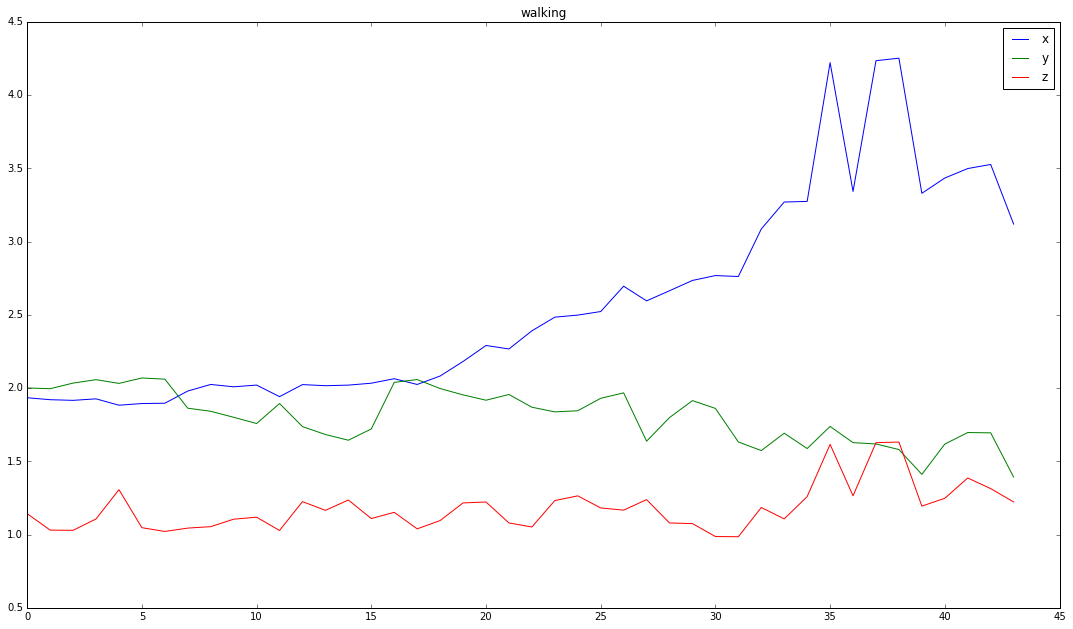

In [12]:
# walking Plot Example
plt.plot([i[0] for i in events["walking"][3][2]], label="x")
plt.plot([i[1] for i in events["walking"][3][2]], label="y")
plt.plot([i[2] for i in events["walking"][3][2]], label="z")
plt.title("walking")
plt.legend()
plt.savefig("figure_4")
plt.show()

In [ ]:
# Filling the Time Series
lengths = [[], [], [], []]
for event in events:
    length_series = []
    for i in range(4):
        for j in range(len(events[event])):
            lengths[i].append(len(events[event][j][i]))
maximum = max([max(lengths[0]), max(lengths[1]), max(lengths[2]), max(lengths[3])])

events_euclidian = events.copy()

for event in events:
    for i in range(4):
        for j in range(len(events[event])):
            time_series = events[event][j][i]
            start = 0
            while len(time_series) < maximum:
                time_series.append(events[event][j][i][start])
                start += 1
            events_euclidian[event][j][i] = time_series

In [ ]:
# Separating in Train and Test Datasets
train_euclidian = []
test_euclidian = []
i = 0
for name in ACTIVITIES:
    length_total = len(events_euclidian[name])
    count = 0
    for event in events_euclidian[name]:
        if count < 0.8 * length_total:
            train_euclidian.append([event, i])
        else:
            test_euclidian.append([event, i])
        count += 1
    i += 1

train = []
test = []
i = 0
for name in ACTIVITIES:
    length_total = len(events[name])
    count = 0
    for event in events[name]:
        if count < 0.8 * length_total:
            train.append([event, i])
        else:
            test.append([event, i])
    i += 1
print(len(train_euclidian))
print(len(test_euclidian))

In [ ]:
# Distances
def euclidian_distance(x, y):
    total_distance = 0
    for i in range(maximum):
        for j in range(4):
            for k in range(3):
                total_distance += (x[0][j][i][k] - y[0][j][i][k]) * (x[0][j][i][k] - y[0][j][i][k])
    return math.sqrt(total_distance)

def DTW_distance(x, y):
    DTW = {}
    total_distance = 0
    for j in range(4):
        for k in range(3):
            for i in range(len(x[0][j])):
                DTW[(i, -1)] = float('inf')
            for i in range(len(y[0][j])):
                DTW[(-1, i)] = float('inf')
            DTW[(-1, -1)] = 0
            
            for i in range(len(x[0][j])):
                for p in range(len(y[0][j])):
                    dist= (x[0][j][i][k] -y[0][j][p][k])**2
                    DTW[(i, p)] = dist + min(DTW[(i-1, p)],DTW[(i, p-1)], DTW[(i-1, p-1)])
                    
            total_distance += DTW[len(x[0][j])-1, len(y[0][j])-1]
    return math.sqrt(total_distance)

def DTW_distance_window(x, y):
    w = 10
    DTW={}
    total_distance = 0
    for j in range(4):
        for k in range(3):
            w = max(w, abs(len(x[0][j])-len(y[0][j])))
            for i in range(-1,len(x[0][j])):
                for p in range(-1,len(y[0][j])):
                    DTW[(i, p)] = float('inf')
            DTW[(-1, -1)] = 0

            for i in range(len(x[0][j])):
                for p in range(max(0, i-w), min(len(y[0][j]), i+w)):
                    dist= (x[0][j][i][k] - y[0][j][p][k])**2
                    DTW[(i, p)] = dist + min(DTW[(i-1, p)],DTW[(i, p-1)], DTW[(i-1, p-1)])

            total_distance += DTW[len(x[0][j])-1, len(y[0][j])-1]
    return math.sqrt(total_distance)

In [ ]:
# KNN
import operator 
def get_neighbors(training_set, test_instance, k, metric=euclidian_distance):
    distances = []
    for x in range(len(training_set)):
        dist = metric(test_instance, training_set[x])
        distances.append((training_set[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    response_results = []
    for x in range(k):
        neighbors.append(distances[x])
    return neighbors

def get_response(neighbors):
    class_votes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][0][1]
        if response in class_votes:
            class_votes[response] += 1
        else:
            class_votes[response] = 1
    sorted_votes = sorted(class_votes.items(), key=operator.itemgetter(1), reverse=False)
    return sorted_votes[0][0]

In [ ]:
# How to use the Classifier - Example
neighbors = get_neighbors(train_euclidian, train_euclidian[100], 1, metric=euclidian_distance)
ACTIVITIES[get_response(neighbors)]

In [ ]:
# Shuffling the test dataset
from random import shuffle
shuffle(test_euclidian)

In [ ]:
# KNN (K = 1) Euclidean Distance
corrects = 0
fails = 0
for x in test_euclidian:
    neighbors = get_neighbors(train_euclidian, x, 1, metric=euclidian_distance)
    if x[1] == get_response(neighbors):
        corrects += 1
    else:
        fails += 1
print("The success rate was {0}".format(100.0 * corrects / (corrects + fails)))

In [ ]:
# It a lot of hours to finish (The partial results are showed periodically)
# KNN (K = 1) DTW
corrects = 0
fails = 0
iterations = 0
total_length = len(test_euclidian)
for x in test_euclidian:
    neighbors = get_neighbors(train_euclidian, x, 1, metric=DTW_distance_window)
    if x[1] == get_response(neighbors):
        corrects += 1
    else:
        fails += 1
    iterations += 1
    print("Calculeted [{0}]. The partial success rate was {1}".format(100 * (iterations / total_length), 100.0 * corrects / (corrects + fails)))

In [ ]:
print("The success rate was {0}".format(100.0 * corrects / (corrects + fails)))